# Time Series Forecasting Version 1

In this notebook, the goal is to explore the OSA data and predict weekly OSA with 2-week overhead. 

Version 1 will only focus in using a machine learning model called Gradient Boosting. 

On next versions, depending on the results of this notebook, we could explore time series specific models such as ARIMA, Phrophet and ETS.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys

sys.path.append('../scripts')

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import utils
import compute_osa

## Load Data

In [6]:
filepath = '../data/source/2021 NAI MT & RMT OSA Data (GMA All SKUs).xlsx'
df = pd.read_excel(filepath, na_values = ['NC', 'NR', '-', 'NF'])
df.head()

,YEAR,MONTH,WEEK,AREA,GROUP,ACCOUNT,OUTLET,Amihan White Vinegar 1L (68),Amihan White Vinegar 2L (69),Amihan White Vinegar 4L (70),...,Locally Pink Guava 1L Tetra Pack,Locally Ripe Mango 1L Tetra Pack (512),UFC Golden Fiesta Canola 1L SUP (553),TOTAL AVAILABILITY,MUST CARRY,NC,OSA,CLASS,MUST CARRY - NC,OSA COMPUTATION
0,2021,JAN,Week 1,GMA,MT 1,LANDMARK,LANDMARK ALABANG (4341),NaN,NaN,NaN,...,NaN,NaN,NaN,85.000000,176,68,0.787037,PARADIGM,108,0.787037
1,2021,JAN,Week 1,GMA,MT 1,LANDMARK,LANDMARK MAKATI (53),NaN,NaN,NaN,...,7.0,7.0,NaN,97.714286,176,59,0.835165,PARADIGM,117,0.835165
2,2021,JAN,Week 1,GMA,MT 1,LANDMARK,LANDMARK TRINOMA (54),NaN,NaN,NaN,...,7.0,7.0,NaN,108.000000,176,59,0.923077,PARADIGM,117,0.923077
3,2021,JAN,Week 1,GMA,MT 1,ROBINSONS,JAYNITHS SUPERMART PASIG (3368),NaN,NaN,NaN,...,7.0,7.0,NaN,55.428571,176,118,0.955665,REGULAR,58,0.955665
4,2021,JAN,Week 1,GMA,MT 1,ROBINSONS,JAYNITHS SUPERMART SAN MATEO (3373),NaN,NaN,NaN,...,0.0,7.0,NaN,54.142857,176,116,0.902381,REGULAR,60,0.902381


In [7]:
len(df)

17707

**Observations:** No missing values on the YEAR, MONTH, WEEK, AREA, GROUP, ACCOUNT and OUTLET columns.

In [8]:
# Number of missing
df.isna().sum().head(7)

YEAR       0
MONTH      0
WEEK       0
AREA       0
GROUP      0
ACCOUNT    0
OUTLET     0
dtype: int64

**Observations:** There are SKUs that have all of their entries to be Null ('NC', 'NR', '-', 'NF').

In [9]:
df.isna().sum().sort_values(ascending=False).head(10)

UFC Spaghetti Sauce 750g (45)                                                      17707
LOCALLY JUICE DRINK POMELO FLAVOR 350ML (417)                                      17707
UFC Ready Recipe  Kare - Kare Mix  45g (323)                                       17707
Grande Spaghetti Catsup Pack (UFC SS 1KG + UFC BC 320G SUP + 1PASTA 800G) (412)    17707
DATU PUTI Sugar Cane Vinegar 350ml (331)                                           17707
LOCALLY JUICE DRINK CALAMANSI FLAVOR 350ML (401)                                   17707
LOCALLY JUICE DRINK DALANDAN FLAVOR 350ML (356)                                    17707
LOCALLY JUICE DRINK GUYABANO FLAVOR 350ML (400)                                    17707
UFC Spagg Sauce w/ Real Cheese & Hotdog 250g (269)                                 17707
UFC Spagg Sauce w/ Real Cheese & Hotdog 500g (274)                                 17707
dtype: int64

## Preprocess Data

### Fix Index
- Create index based on datetime (assume 1st monday of week), outlet name

In [10]:
# Create a year-week (e.g. 2022-W1) series
year_week = df['YEAR'].astype('int').astype('str') + '-W' +  df['WEEK'].str.split().str[1]

# Convert year week to datetime
df_clean = df.copy()
df_clean['DATE'] = year_week.apply(utils.convert_year_week_to_date)

# Setting index
df_clean = df_clean.set_index(['OUTLET', 'DATE']).drop(['YEAR', 'MONTH', 'WEEK'], axis=1)

# Sort index
df_clean = df_clean.sort_index()

### [Not implemented] Remove SKUs with all Null Records
Not implemented because OSA computation relies on having all SKUs be available.

In [11]:
# column_count_before_removal = len(df_clean.columns)
# df_clean = df_clean[df_clean.columns[df_clean.isna().sum() != len(df)]]
# print(f"There were {column_count_before_removal-len(df_clean.columns)} SKUs removed.")

### Filling Null values with -1
Note: Given we will be using a tree-based algorithm, this would mitigate the problem that could arise from this.
We used -1 to differentiate it with 0. 

In [12]:
df_clean = df_clean.fillna(-1)
df_clean.sample(5)

,,AREA,GROUP,ACCOUNT,Amihan White Vinegar 1L (68),Amihan White Vinegar 2L (69),Amihan White Vinegar 4L (70),Amihan White Vinegar 350Ml (307),Amihan White Vinegar 385Ml (308),DATU PUTI Brewed Soysauce Less Sodium 265ml (314),DATU PUTI Magic 250ml (311),...,Locally Pink Guava 1L Tetra Pack,Locally Ripe Mango 1L Tetra Pack (512),UFC Golden Fiesta Canola 1L SUP (553),TOTAL AVAILABILITY,MUST CARRY,NC,OSA,CLASS,MUST CARRY - NC,OSA COMPUTATION
OUTLET,DATE,,,,,,,,,,,,,,,,,,,,,
SSMI - SM HYPERMARKET MANDALUYONG (3781),2021-09-13,GMA,MT 2,SSMI,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,7.0,...,-1.0,-1.0,7.0,100.857143,176,75,0.998586,REGULAR,101,0.998586
SMC-SAVEMORE MARKET M. PLACE SOUTH TRIANGLE Q.C (3446),2021-09-06,GMA,MT 2,SMCO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,7.0,72.857143,176,100,0.958647,REGULAR,76,0.958647
RUSTANS MARKET PLACE VENICE GRAND MCKINLEY (FORMER RSE) (4904),2021-11-08,GMA,MT 1,RUSTANS,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,7.0,7.0,7.0,60.142857,176,112,0.939732,REGULAR,64,0.939732
SUPER 8 ARCADE CUBAO (FARMERS) (4181),2021-04-26,GMA,MT 3,SUPER 8,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,100.000000,176,74,0.980392,REGULAR,102,0.980392
LANDMARK TRINOMA (54),2021-12-06,GMA,MT 1,LANDMARK,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,...,-1.0,-1.0,-1.0,110.714286,176,61,0.962733,PARADIGM,115,0.962733


## Prepare Data for Prediction

In [13]:
other_cols = ['TOTAL AVAILABILITY', 'MUST CARRY', 'NC', 'OSA', 'CLASS', 'MUST CARRY - NC', 'OSA COMPUTATION', 'GROUP', 'ACCOUNT', 'AREA']
OSA_cols = list(set(df_clean.columns) - set(other_cols))

## EDA

### What is the distribution of individual OSA values?

Based on the plots below, generally the values are -1, 0 or 7. 
This just shows how binary the values of OSA is (disregarding -1 as it means Null). Maybe in the future, we can use a binary specific model to predict.

The same is also true for the OSA for each outlet. Check Appendix A.

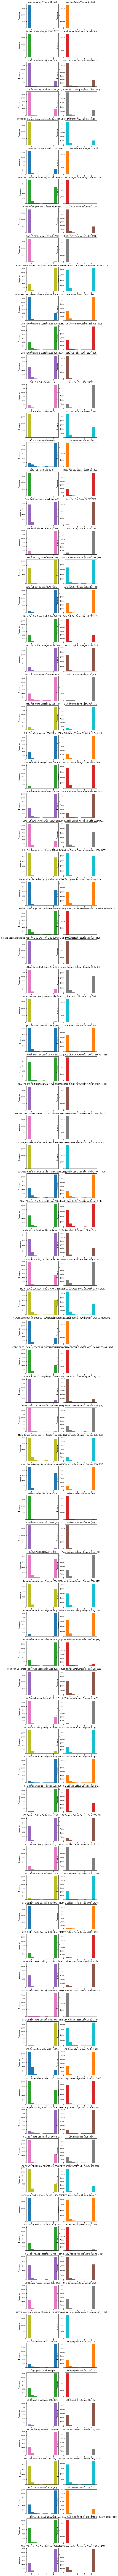

In [14]:
df_clean[sorted(OSA_cols)].plot.hist(subplots=True, 
                                     layout=(-1, 2), 
                                     figsize=(8, 300),
                                     legend=False,
                                     title=sorted(OSA_cols), 
                                     sharex=False);

### How many weeks of data per OUTLET?
There are outlets with so few data points. In this analysis, we might have to remove outlets with less than 12 weeks (about 3 months) worth of data. 

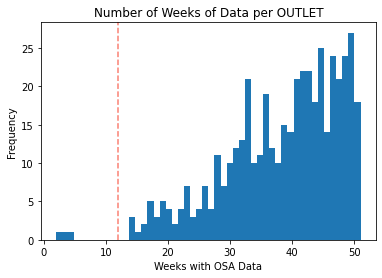

In [15]:
ax = df_clean.groupby(['OUTLET']).count()['OSA'].plot.hist(bins=50)
ax.axvline(12, ls='--', color='salmon')
ax.set_title("Number of Weeks of Data per OUTLET")
ax.set_xlabel('Weeks with OSA Data');

#### Removal of OUTLETS with less than 12 weeks of data. 

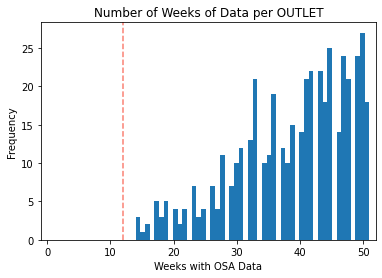

In [16]:
counts = df_clean.groupby(['OUTLET']).count()['OSA']
df_clean = df_clean.loc[counts[counts > 12].index] 
ax = df_clean.groupby(['OUTLET']).count()['OSA'].plot.hist(bins=50)
ax.set_xlim(-1, 52)
ax.axvline(12, ls='--', color='salmon')
ax.set_title("Number of Weeks of Data per OUTLET")
ax.set_xlabel('Weeks with OSA Data');

## Prepare Data for Prediction

### Train-Test Split
In this notebook, let's split the data per outlet into 70% train and 30% test sets.

In [17]:
train_percent = 70
outlets = df_clean.reset_index()['OUTLET'].unique()

train_data = []
test_data = []

for outlet in outlets:
    current_data = df_clean.loc[outlet]
    current_data['OUTLET'] = outlet
    num_weeks = len(current_data)
    train_idx = int(num_weeks * train_percent/100)
    train_data += [current_data.iloc[:train_idx]]
    test_data += [current_data.iloc[train_idx:]]

train_data = pd.concat(train_data).reset_index().set_index(['OUTLET', 'DATE'])
test_data = pd.concat(test_data).reset_index().set_index(['OUTLET', 'DATE'])

print(f"Train:Test\n{train_percent}:{100-train_percent}\n{len(train_data)}:{len(test_data)}")

Train:Test
70:30
12192:5506


### Feature Engineering

Our goal is to predict if the next next week's OSA would reach the 95% threshold. 
In other words, if the OSA for this week is referred as **Week 0 OSA**, then we want to predict if **Week 2's OSA** passes the threshold. 

Let's have 8 weeks of lookback window (Weeks -7 to Week 0) to predict if the OSA 2 weeks ahead would pass the 95% threshold. 

In [18]:
X_train, y_train = utils.get_XY(train_data, 
                                window_size=8, 
                                steps_ahead=2)
X_test, y_test = utils.get_XY(test_data, 
                              window_size=8, 
                              steps_ahead=2)

print("X_train")
display(X_train.head(2))
print(X_train.shape)

print("y_train")
display(y_train.to_frame().head(2))
print(y_train.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 600.99it/s]


X_train


Week -7: Amihan White Vinegar 1L (68)  \
OUTLET                   DATE                                                
FREE CHOICE PASIG (3673) 2021-02-22                                   -1.0   
                         2021-03-01                                   -1.0   

                                     Week -7: Amihan White Vinegar 2L (69)  \
OUTLET                   DATE                                                
FREE CHOICE PASIG (3673) 2021-02-22                                   -1.0   
                         2021-03-01                                   -1.0   

                                     Week -7: Amihan White Vinegar 4L (70)  \
OUTLET                   DATE                                                
FREE CHOICE PASIG (3673) 2021-02-22                                   -1.0   
                         2021-03-01                                   -1.0   

                                     Week -7: Amihan White Vinegar 350Ml (307)  \
OUTLET                   DATE                                                    
FREE CHOICE PASIG (3673) 2021-02-22                                       -1.0   
                         2021-03-01                                       -1.0   

                                     Week -7: Amihan White Vinegar 385Ml (308)  \
OUTLET                   DATE                                                    
FREE CHOICE PASIG (3673) 2021-02-22                                       -1.0   
                         2021-03-01                                       -1.0   

                                     Week -7: DATU PUTI Brewed Soysauce Less Sodium 265ml (314)  \
OUTLET                   DATE                                                                     
FREE CHOICE PASIG (3673) 2021-02-22                                               -1.0            
                         2021-03-01                                               -1.0            

                                     Week -7: DATU PUTI Magic 250ml (311)  \
OUTLET                   DATE                                               
FREE CHOICE PASIG (3673) 2021-02-22                                  -1.0   
                         2021-03-01                                  -1.0   

                                     Week -7: DATU PUTI Mansi 250ml (312)  \
OUTLET                   DATE                                               
FREE CHOICE PASIG (3673) 2021-02-22                                  -1.0   
                         2021-03-01                                  -1.0   

                                     Week -7: DATU PUTI Natural Cane Vinegar 265ml (313)  \
OUTLET                   DATE                                                              
FREE CHOICE PASIG (3673) 2021-02-22                                               -1.0     
                         2021-03-01                                               -1.0     

                                     Week -7: Datu Puti Oysterrific Oyster Sauce 30g (262)  \
OUTLET                   DATE                                                                
FREE CHOICE PASIG (3673) 2021-02-22                                               -1.0       
                         2021-03-01                                               -1.0       

                                     ...  Week 0: ACCOUNT_RUSTANS  \
OUTLET                   DATE        ...                            
FREE CHOICE PASIG (3673) 2021-02-22  ...                      0.0   
                         2021-03-01  ...                      0.0   

                                     Week 0: ACCOUNT_SHOPWISE  \
OUTLET                   DATE                                   
FREE CHOICE PASIG (3673) 2021-02-22                       0.0   
                         2021-03-01                       0.0   

                                     Week 0: ACCOUNT_SMCO  \
OUTLET                   DATE                               
FREE CHOICE PASIG (

(8097, 1592)
y_train


Week +2: OSA>=95%
OUTLET                   OUTLET                   DATE                         
FREE CHOICE PASIG (3673) FREE CHOICE PASIG (3673) 2021-02-22              False
                                                  2021-03-01              False

(8097,)


## Time Series Prediction

In [19]:
%%time
clf = GradientBoostingClassifier(n_estimators=50, 
                                 random_state=0,
                                 learning_rate=0.1,
                                 max_depth=2
                                )
clf.fit(X_train, y_train)

Wall time: 9.89 s


GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=0)

In [20]:
print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

Train Accuracy: 0.7655921946399901
Test Accuracy: 0.8204456094364351


<AxesSubplot:>

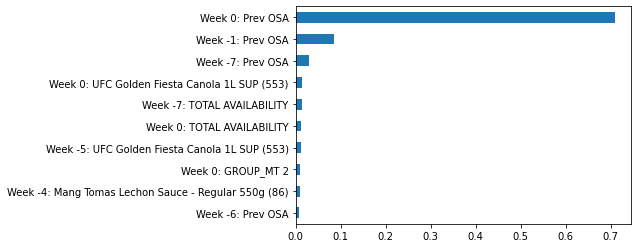

In [21]:
feat_importance = pd.Series(clf.feature_importances_, 
                             index=X_train.columns)
feat_importance.sort_values().tail(10).plot.barh()

## Comparison to Baseline Models

In [22]:
y_pred_gbm = clf.predict(X_test)
y_pred_week0 = X_test['Week 0: Prev OSA'] >= 0.95
y_pred_mean = X_test.filter(like='OSA').mean(axis=1) >= 0.95

In [23]:
pd.DataFrame(
    {"GBM": {
        'Accuracy': accuracy_score(y_test, y_pred_gbm),
        'Recall': recall_score(y_test, y_pred_gbm)},
     "Baseline: Current Week's OSA": {
         'Accuracy': accuracy_score(y_test, y_pred_week0),
         'Recall': recall_score(y_test, y_pred_week0)},\
     "Baseline: Average Last 8 Week's OSA": {
         'Accuracy': accuracy_score(y_test, y_pred_mean),
         'Recall': recall_score(y_test, y_pred_mean)},
    }
).T

,Accuracy,Recall
GBM,0.820446,0.932668
Baseline: Current Week's OSA,0.810616,0.906899
Baseline: Average Last 8 Week's OSA,0.807339,0.913549


## Appendix

### Appendix A. What is the distribution of OSA per outlet?

In [24]:
# (df_clean.reset_index()[['OUTLET'] + sorted(OSA_cols)]
#  .melt(id_vars='OUTLET', 
#        value_vars=sorted(OSA_cols))
#  .groupby('OUTLET')
#  .plot
#  .hist('value'))

### Appendix B. OLD: Forecasting (Baseline Model)

Our goal is to predict the next next week's OSA. If the OSA for this week is referred as Week 0 OSA, we want to predict Week 2's OSA. 

We will create a baseline model to predict Week 2's OSA. We will use the mean OSA from the last 4 weeks with known OSA (Week -3 to Week 0) as a baseline.

#### Baseline Prediction

In [25]:
# Rolling Mean
rolling_mean = df_clean['OSA'].groupby(['OUTLET']).rolling(4).mean()

# Shift by 2 weeks
shifted_by_2_weeks = rolling_mean.groupby(['OUTLET']).shift(2)

df_clean['OSA Baseline Prediction'] = shifted_by_2_weeks.values
display(df_clean[['OSA Baseline Prediction', 'OSA']].head(10))

OSA Baseline Prediction       OSA
OUTLET                   DATE                                         
FREE CHOICE PASIG (3673) 2021-01-04                      NaN  0.689189
                         2021-01-11                      NaN  0.696911
                         2021-01-18                      NaN  0.662162
                         2021-01-25                      NaN  0.669884
                         2021-02-01                      NaN  0.675676
                         2021-02-08                 0.679537  0.680272
                         2021-02-15                 0.676158  0.820168
                         2021-02-22                 0.671999  0.745847
                         2021-03-01                 0.711500  0.749169
                         2021-03-08                 0.730491  0.720706

#### Baseline Performance (for All Available Data [No test/train set yet])
Note: We might prefer using RMSE than MAE because we want to penalize models with larger errors as our goal is to predict those quick/big dips in OSA. 

In [26]:
result = df_clean[['OSA Baseline Prediction', 'OSA']].dropna()
y_pred = result['OSA Baseline Prediction'] 
y_true = result['OSA']
print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")

MAE: 0.06
RMSE: 0.11
